In [110]:
import pandas as pd
from pandas import read_csv
from datetime import datetime
# load and review raw data
dataset = read_csv('ROWSolcast-8.1.2018_8.2.2019.csv')

print(dataset.head(5))
print(len(dataset))

              PeriodEnd           PeriodStart Period  Azimuth  CloudOpacity  \
0  2018-08-01T00:15:00Z  2018-08-01T00:10:00Z   PT5M      -39          16.5   
1  2018-08-01T00:20:00Z  2018-08-01T00:15:00Z   PT5M      -38           3.0   
2  2018-08-01T00:25:00Z  2018-08-01T00:20:00Z   PT5M      -37           8.5   
3  2018-08-01T00:30:00Z  2018-08-01T00:25:00Z   PT5M      -36          15.0   
4  2018-08-01T00:35:00Z  2018-08-01T00:30:00Z   PT5M      -35           8.5   

   Dhi  Dni  Ebh  Ghi  Zenith  
0  139  400  163  302      66  
1  103  628  257  360      66  
2  135  513  213  348      65  
3  168  386  165  333      65  
4  136  529  233  368      64  
105423


From above dataset, there are ten columns in total,in which "PeriodStart" and "Period" are useless in my case and the format of the date need to be changed. 

In [74]:
# Drop two useless columns and adjust format
dataset["PeriodEnd"] = pd.to_datetime(dataset["PeriodEnd"], format="%Y-%m-%dT%H:%M:%SZ")
dataset.drop(['PeriodStart', 'Period'], inplace = True, axis = 1) #if no inplace = True, drop will not work

In [75]:
cols = dataset.columns.tolist()
cols = ["PeriodEnd", "Ghi", "Azimuth", "CloudOpacity", "Dhi", "Dni", "Ebh","Zenith"]
dataset = dataset[cols]
print(dataset.head(5))

            PeriodEnd  Ghi  Azimuth  CloudOpacity  Dhi  Dni  Ebh  Zenith
0 2018-08-01 00:15:00  302      -39          16.5  139  400  163      66
1 2018-08-01 00:20:00  360      -38           3.0  103  628  257      66
2 2018-08-01 00:25:00  348      -37           8.5  135  513  213      65
3 2018-08-01 00:30:00  333      -36          15.0  168  386  165      65
4 2018-08-01 00:35:00  368      -35           8.5  136  529  233      64


In [76]:
# based on the timezone, adjust the datetime
import pytz
from pytz import timezone

dataset['PeriodEnd'] = pd.to_datetime(dataset['PeriodEnd'])
dataset.set_index('PeriodEnd', drop = False, inplace = True)
print(dataset.index.tzinfo)

print(len(pytz.common_timezones))
# print(pytz.common_timezones)


Mt_Gambier= timezone('Australia/Adelaide')
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(Mt_Gambier)
dataset.drop('PeriodEnd',inplace = True, axis = 1)
dataset.head()
# dataset.to_csv("cleaned1stMtGa.csv")

None
440


,Ghi,Azimuth,CloudOpacity,Dhi,Dni,Ebh,Zenith
PeriodEnd,,,,,,,
2018-08-01 09:45:00+09:30,302,-39,16.5,139,400,163,66
2018-08-01 09:50:00+09:30,360,-38,3.0,103,628,257,66
2018-08-01 09:55:00+09:30,348,-37,8.5,135,513,213,65
2018-08-01 10:00:00+09:30,333,-36,15.0,168,386,165,65
2018-08-01 10:05:00+09:30,368,-35,8.5,136,529,233,64


In [77]:
dataset.to_csv("cleaned1stMtGa.csv")

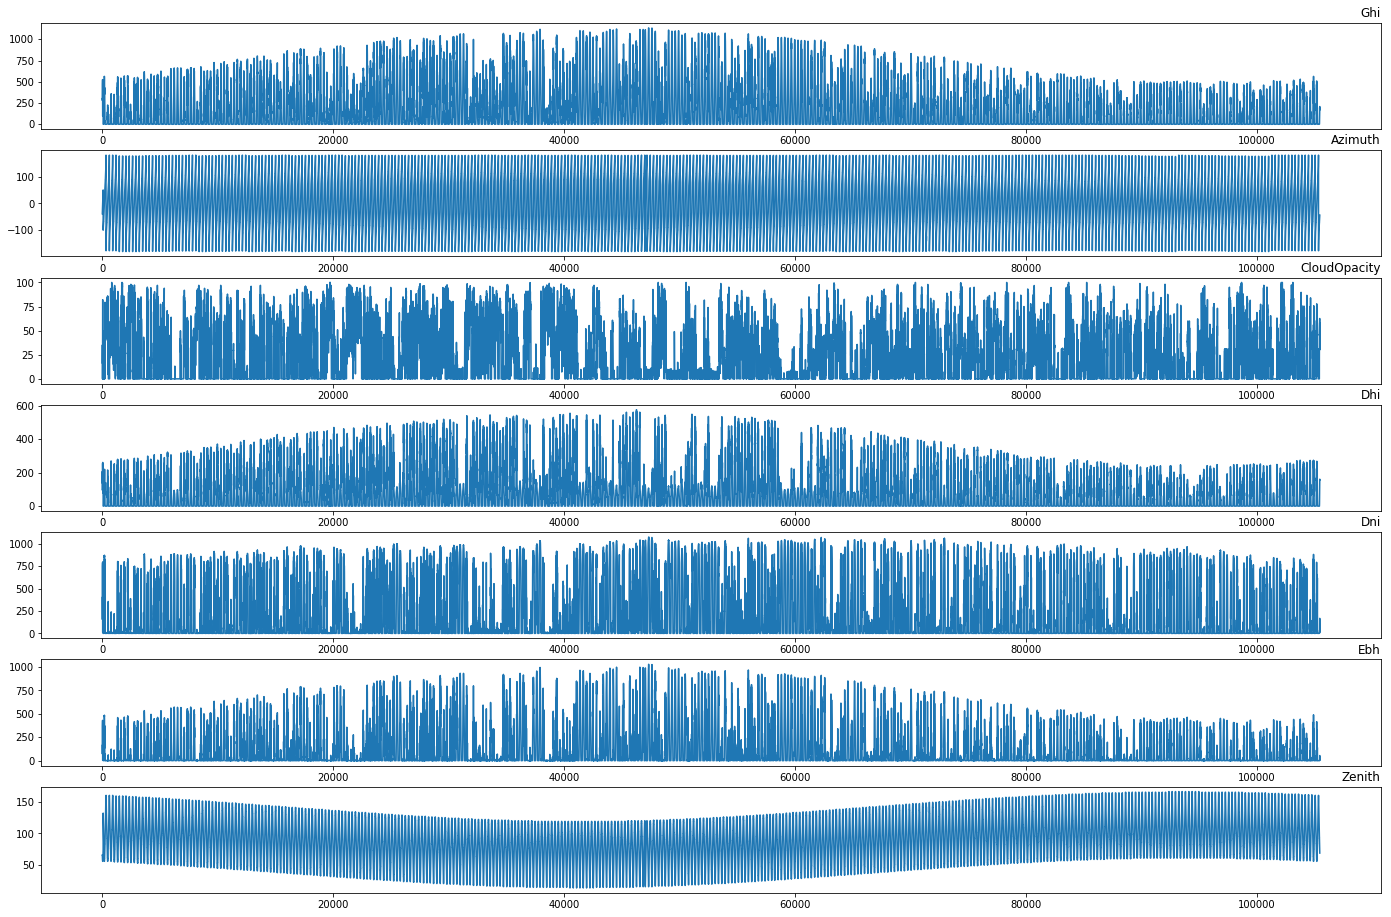

In [183]:
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
# load dataset
dataset = read_csv('cleaned1stMtGa.csv', header=0, index_col='PeriodEnd')
values = dataset.values
# specify columns to plot
groups = [0,1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=1, loc='right')
    i += 1
pyplot.show()
# make plot larger
pyplot.rcParams['figure.figsize']=24,16
# fig.savefig('my_figure.png') 

In [200]:
from pandas import concat
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# convert time series to supervised learning based on Jason's tutorial of series to supervised
#def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

 
# load dataset
dataset = read_csv('cleaned1stMtGa.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.266079   0.391667      0.165   0.241319   0.372093   0.158560   
2   0.317181   0.394444      0.030   0.178819   0.584186   0.250000   
3   0.306608   0.397222      0.085   0.234375   0.477209   0.207198   
4   0.293392   0.400000      0.150   0.291667   0.359070   0.160506   
5   0.324229   0.402778      0.085   0.236111   0.492093   0.226654   

   var7(t-1)   var1(t)  
1   0.342105  0.317181  
2   0.342105  0.306608  
3   0.335526  0.293392  
4   0.335526  0.324229  
5   0.328947  0.350661  


In [230]:
# split into train and test sets
values = reframed.values
#using   days as training data
n_train_hours = 250 * 288 #5 min interval  12*24==288 one day
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(72000, 1, 7) (72000,) (33422, 1, 7) (33422,)


Train on 72000 samples, validate on 33422 samples
Epoch 1/50
 - 18s - loss: 0.0543 - acc: 0.4410 - val_loss: 0.0155 - val_acc: 0.5639
Epoch 2/50
 - 10s - loss: 0.0254 - acc: 0.4410 - val_loss: 0.0141 - val_acc: 0.5639
Epoch 3/50
 - 11s - loss: 0.0233 - acc: 0.4410 - val_loss: 0.0126 - val_acc: 0.5639
Epoch 4/50
 - 11s - loss: 0.0204 - acc: 0.4410 - val_loss: 0.0102 - val_acc: 0.5639
Epoch 5/50
 - 10s - loss: 0.0173 - acc: 0.4410 - val_loss: 0.0103 - val_acc: 0.5639
Epoch 6/50
 - 11s - loss: 0.0162 - acc: 0.4410 - val_loss: 0.0092 - val_acc: 0.5639
Epoch 7/50
 - 11s - loss: 0.0157 - acc: 0.4410 - val_loss: 0.0088 - val_acc: 0.5639
Epoch 8/50
 - 12s - loss: 0.0153 - acc: 0.4410 - val_loss: 0.0083 - val_acc: 0.5639
Epoch 9/50
 - 12s - loss: 0.0149 - acc: 0.4410 - val_loss: 0.0079 - val_acc: 0.5639
Epoch 10/50
 - 11s - loss: 0.0145 - acc: 0.4410 - val_loss: 0.0075 - val_acc: 0.5639
Epoch 11/50
 - 13s - loss: 0.0142 - acc: 0.4410 - val_loss: 0.0073 - val_acc: 0.5639
Epoch 12/50
 - 11s - los

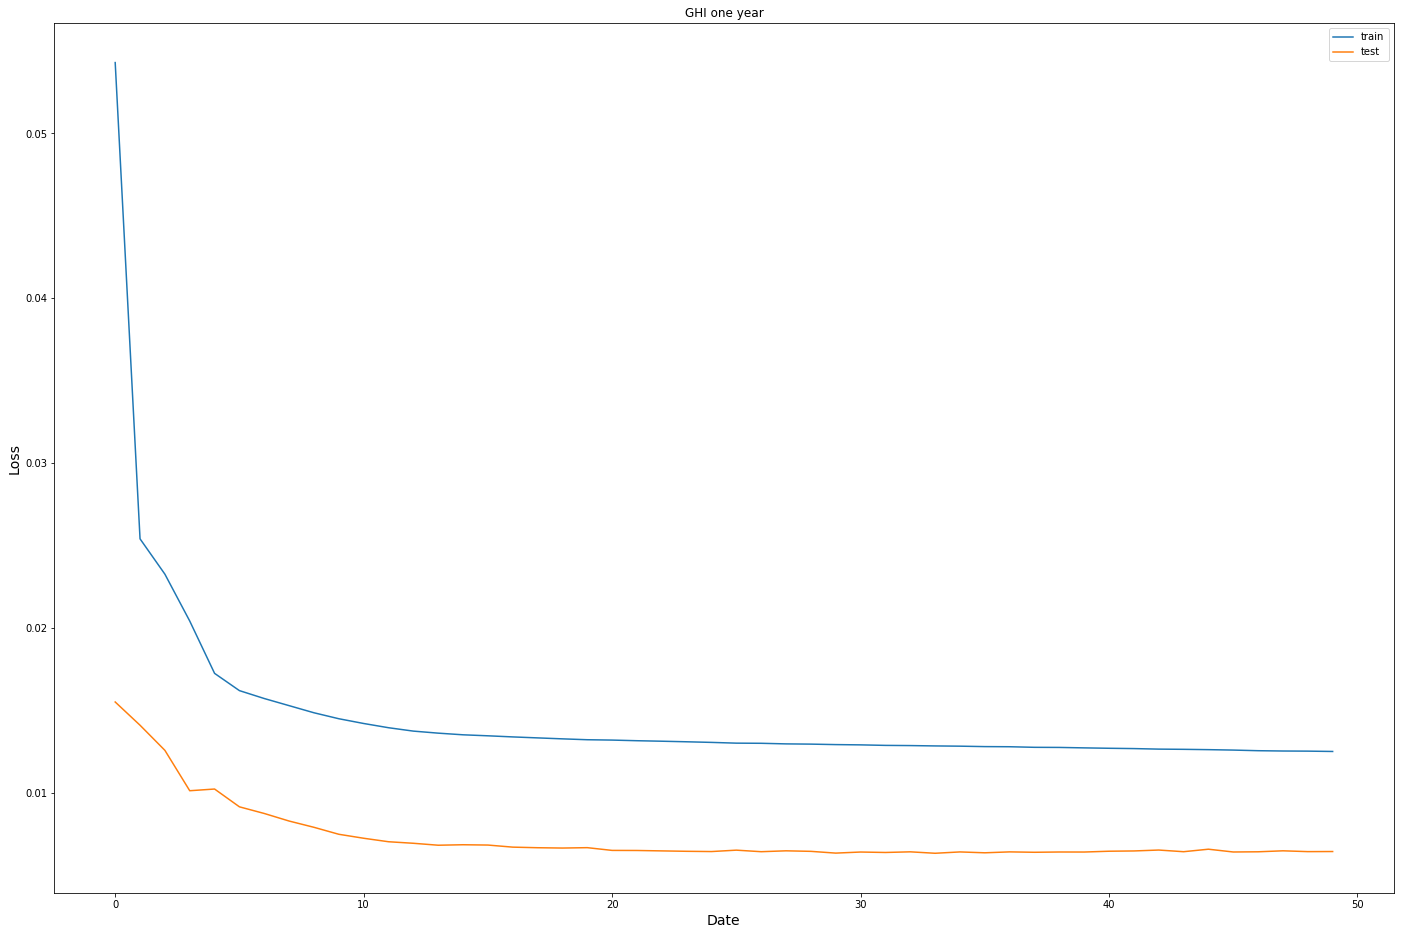

In [231]:
# design network
from keras.layers import Embedding
from keras import optimizers

# sgd = optimizers.SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)

model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))#, return_sequences=True)
# model.add(LSTM(64)) didnt show good result might becuase of the insufficient of dataset
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='mae', optimizer=sgd, metrics=['accuracy'])

model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy']) #better result
#because this is regression problem. The accuracy is meaningless to plot.
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot error
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('GHI one year')
pyplot.xlabel('Date',fontsize=14)
pyplot.ylabel('Loss',fontsize=14)

pyplot.legend()
pyplot.show()

In [232]:
from numpy import concatenate
from math import sqrt
import pandas as pd
import numpy as np
from keras.models import load_model

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

model.save('my_model_250V2.h5')  # creates a HDF5 file 'my_model_250V2.h5'

In [245]:
# del model
model = load_model('my_model_250V2.h5')
# show the RMSE result
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print(inv_y)
print(inv_yhat)
# seperately save the output for future use. it is only a rough deal for plot the relation of observed and predicted.
numpy.savetxt("VSo.csv",inv_y, delimiter=",")
numpy.savetxt("VSp.csv",inv_yhat, delimiter=",")
# print the type of output
print('Observed data is:', type(inv_y))
print('Predicted data is:', type(inv_yhat))
print(len(inv_y))
print(len(inv_yhat))


Test RMSE: 18.838
[304. 336. 372. ... 200. 183. 170.]
[320.24075 319.22775 355.66766 ... 223.81866 218.02277 198.94972]
Observed data is: <class 'numpy.ndarray'>
Predicted data is: <class 'numpy.ndarray'>
33422
33422


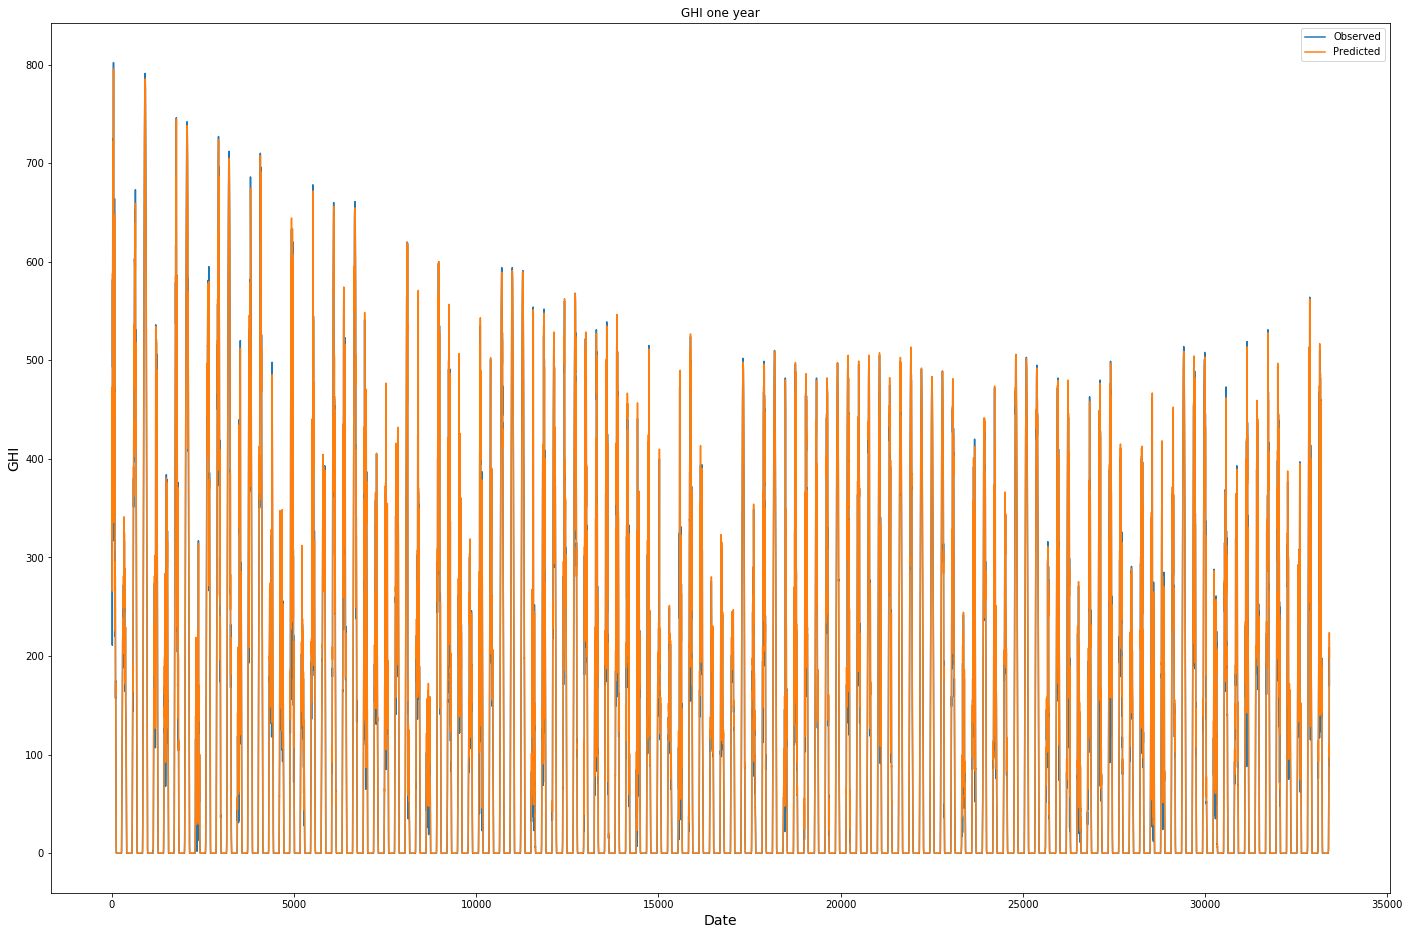

In [236]:
# plot the testing result 
pyplot.plot(inv_y, label='Observed')
pyplot.plot(inv_yhat, label='Predicted')
pyplot.title('GHI one year')
pyplot.xlabel('Date',fontsize=14)
pyplot.ylabel('GHI',fontsize=14)
pyplot.legend()
pyplot.show()

In [248]:
# from above figure, it is hard to get a conclusion. Therefore, prepare to plot what I saved eariler


import pandas as pd
from pandas import read_csv
from datetime import datetime
# load and review raw data
# dataset = read_csv('VS.csv')

print(dataset.head(5))
print(len(dataset))

#Generate a datetime index
dt=pd.Series(pd.period_range('2019-04-09 08:20:00', freq='5min', periods=33422))
dt.to_csv('VS_index.csv')
df = read_csv('VS_index.csv')

print(df.head(5))
print(len(df))

   Observed  Predicted
0     304.0      320.2
1     336.0      319.2
2     372.0      355.7
3     391.0      389.7
4     408.0      409.7
33422


/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if sys.path[0] == '':


   0  2019-04-09 08:20
0  1  2019-04-09 08:25
1  2  2019-04-09 08:30
2  3  2019-04-09 08:35
3  4  2019-04-09 08:40
4  5  2019-04-09 08:45
33421


       Datetime  Observed  Predicted
0  9/4/19 08:20       304      320.2
1  9/4/19 08:25       336      319.2
2  9/4/19 08:30       372      355.7
3  9/4/19 08:35       391      389.7
4  9/4/19 08:40       408      409.7


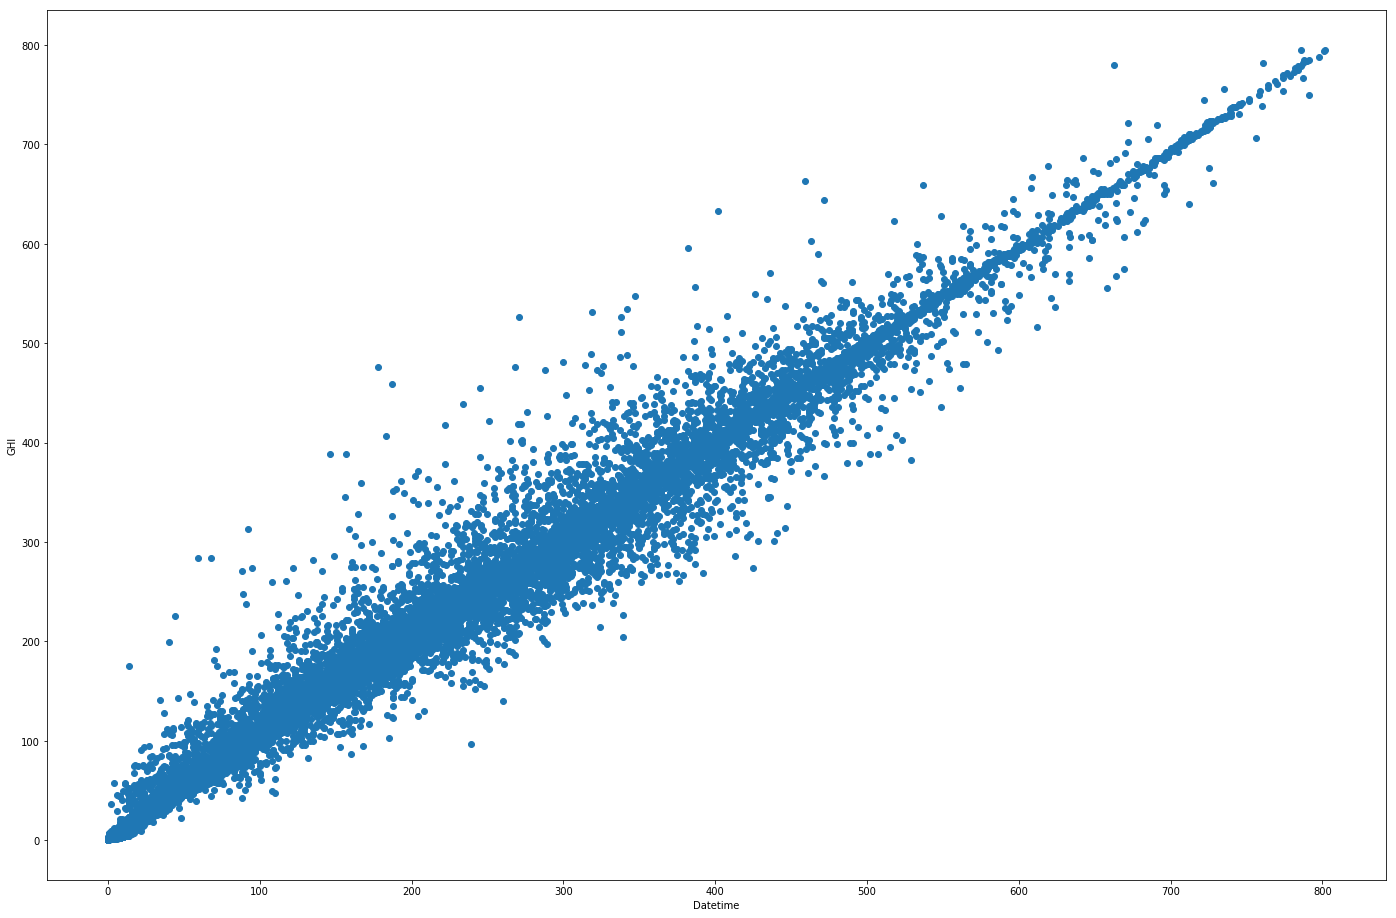

In [257]:
# plot the result by scatter
from sklearn.metrics import accuracy_score
df = read_csv('VS.csv')
print(df.head())

observe = df['Observed']
predict = df['Predicted']
plt.scatter(observe, predict)
plt.xlabel('Datetime')
plt.ylabel('GHI')
plt.show()
